In [1]:
import soundfile # to read audio file
import numpy as np #multi-dimensional arrays
import librosa # to extract speech features
import glob #to retrieve files/pathnames
import os #provides functions for creating and removing a directory(folder)
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are

In [2]:
#extract features from soundfile
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
        if contrast:
            contrast=np.mean(librosa.feature.spectral_contrast(S=stft, sr=srate).T,axis=0)
            result=np.hstack((result, contrast))
        if tonnetz:
            tonnetz=np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=srate).T,axis=0)
            result=np.hstack((result, tonnetz))
    return result

In [3]:
#Emotions available in RAVDESS Dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#Emotions we want to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [4]:
#load the data
def load_data(test_size=0.25):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'E:\\DataFlair\\clean_speech\\*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [5]:
#Split the dataset
#testing data 25%, training data 75%
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
#mapping of testing data(predicted emotions) with corresponding filenames
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
#print(*test_filename,sep="\n")

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)


In [6]:
#Get the shape(number of elements) of the training and testing datasets
#print((x_train.shape[0], x_test.shape[0])) (576, 192)
#Get the number of features extacted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [9]:
#Initialise MLPClassifier
model_params = {
    'alpha': 0.01,
    'batch_size': 200,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (600,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
model1 = MLPClassifier(**model_params)
#Train the model
print("Training the model...")
model1.fit(x_train, y_train)
#Predict values for test set
y_pred = model1.predict(x_test)
#Calculate accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Training the model...
Accuracy: 84.90%


In [10]:
#create pkl file to save model
import pickle
Pkl_Filename = "Speech_Emotion_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model1, file)

In [11]:
#load model from file
with open(Pkl_Filename, 'rb') as file:  
    Speech_Emotion_Detection_Model = pickle.load(file)

Speech_Emotion_Detection_Model

MLPClassifier(alpha=0.01, batch_size=200, hidden_layer_sizes=(600,),
              learning_rate='adaptive', max_iter=500)

In [12]:
#Predict values for test set using saved model
y_pred = Speech_Emotion_Detection_Model.predict(x_test)

In [13]:
#create csv file of filenames with emotions
import numpy as np #multi-dimensional array
import pandas as pd #data analysis
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
#print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')
y_pred1[:]

,predictions,file_names
0,fearful,03-01-06-01-02-02-01.wav
1,happy,03-01-03-01-02-01-21.wav
2,happy,03-01-07-01-02-02-04.wav
3,calm,03-01-02-02-01-02-24.wav
4,disgust,03-01-07-01-02-02-19.wav
...,...,...
187,disgust,03-01-07-01-02-02-14.wav
188,happy,03-01-03-02-02-02-02.wav
189,fearful,03-01-06-02-01-01-14.wav
190,disgust,03-01-07-01-01-02-02.wav


In [14]:
#To get Classification Report
from sklearn.metrics import classification_report #Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        calm       0.92      0.91      0.92        54
     disgust       0.80      0.84      0.82        44
     fearful       0.88      0.79      0.83        53
       happy       0.78      0.85      0.81        41

    accuracy                           0.85       192
   macro avg       0.85      0.85      0.85       192
weighted avg       0.85      0.85      0.85       192



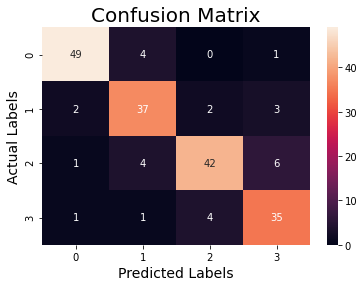

In [15]:
#To Draw Confusion Matrix
from sklearn.metrics import confusion_matrix #Confusion_Matrix
import matplotlib.pyplot as plt #to create a figure & to plot area
import pandas as pd #data analysis
import seaborn as sns #data visualization based on matplotlib
cm=confusion_matrix(y_test,y_pred)
df_cm=pd.DataFrame(cm)
sns.heatmap(df_cm,annot=True,fmt='')
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels", size=14)
plt.ylabel("Actual Labels", size=14)
plt.savefig("Initial_Model_Confusion_Matrix.png")
plt.show()

In [16]:
import pyaudio #to record and play audio
import wave #read and write wav files
THRESHOLD = 500
CHUNK_SIZE = 1024
FORMAT = pyaudio.paInt16
RATE = 16000
SILENCE = 30

In [17]:
#Returns 'True' if below the 'silent' threshold
def is_silent(snd_data):
    return max(snd_data) < THRESHOLD

In [18]:
#Average the volume out
from array import array
def normalize(snd_data):
    MAXIMUM = 16384
    times = float(MAXIMUM)/max(abs(i) for i in snd_data)
    r = array('h')
    for i in snd_data:
        r.append(int(i*times))
    return r

In [19]:
#Trim the blank spots at the start and end
def trim(snd_data):
    def _trim(snd_data):
        snd_started = False
        r = array('h')
        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)
            elif snd_started:
                r.append(i)
        return r
    # Trim to the left
    snd_data = _trim(snd_data)
    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

In [20]:
#Add silence to the start and end of 'snd_data' of length 'seconds' (float)
def add_silence(snd_data, seconds):
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

In [21]:
#Record words from the microphone and return the data as an array of signed shorts.
#Normalizes the audio, trims silence from the start and end
#and pads with 0.5 seconds of blank sound to make sure VLC et al can play it without getting chopped off.
from sys import byteorder
def record():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)
    num_silent = 0
    snd_started = False
    r = array('h')
    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)
        silent = is_silent(snd_data)
        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True
        if snd_started and num_silent > SILENCE:
            break
    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()
    r = normalize(r)
    r = trim(r)
    r = add_silence(r, 0.5)
    return sample_width, r

In [22]:
#Records from the microphone and outputs the resulting data to path
from struct import pack
def record_to_file(path):
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)
    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [23]:
if __name__ == "__main__":
    print("Please talk")
    filename = "test.wav"
    # record the file (start talking)
    record_to_file(filename)
    # extract features and reshape it
    features = extract_feature(filename, mfcc=True, chroma=True, mel=True).reshape(1, -1)
    # predict
    result = Speech_Emotion_Detection_Model.predict(features)[0]
    # show the result !
    print("result:", result)

Please talk
result: fearful
